# 1、对数据集进行处理，转换成适合关联规则挖掘的形式

## 在后文中选用Apriori算法进行关联规则挖掘。由于Apriori算法适用于对二值属性进行分析，因此在数据预处理阶段需要将原数据中的多值属性转换为二值属性。

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import math
data = pd.read_csv("/Users/liuhao/Desktop/数据挖掘/刘豪_3120191022/youtube-new/INvideos.csv")
data.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,kzwfHumJyYc,17.14.11,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,2017-11-12T12:20:39.000Z,"sharry mann|""sharry mann new song""|""sharry man...",1096327,33966,798,882,https://i.ytimg.com/vi/kzwfHumJyYc/default.jpg,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...
1,zUZ1z7FwLc8,17.14.11,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",HJ NEWS,25,2017-11-13T05:43:56.000Z,"पीरियड्स के समय|""पेट पर पति करता ऐसा""|""देखकर द...",590101,735,904,0,https://i.ytimg.com/vi/zUZ1z7FwLc8/default.jpg,True,False,False,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं..."
2,10L1hZ9qa58,17.14.11,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,TFPC,24,2017-11-12T15:48:08.000Z,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,473988,2011,243,149,https://i.ytimg.com/vi/10L1hZ9qa58/default.jpg,False,False,False,Watch Stylish Star Allu Arjun @ ChaySam Weddin...
3,N1vE8iiEg64,17.14.11,Eruma Saani | Tamil vs English,Eruma Saani,23,2017-11-12T07:08:48.000Z,"Eruma Saani|""Tamil Comedy Videos""|""Films""|""Mov...",1242680,70353,1624,2684,https://i.ytimg.com/vi/N1vE8iiEg64/default.jpg,False,False,False,This video showcases the difference between pe...
4,kJzGH0PVQHQ,17.14.11,why Samantha became EMOTIONAL @ Samantha naga ...,Filmylooks,24,2017-11-13T01:14:16.000Z,"Filmylooks|""latest news""|""telugu movies""|""telu...",464015,492,293,66,https://i.ytimg.com/vi/kJzGH0PVQHQ/default.jpg,False,False,False,why Samantha became EMOTIONAL @ Samantha naga ...


## 原数据集一共含有16个属性，考虑到数据转换的复杂程度，这里选取了8列具有分析价值的进行关联规则挖掘，分别为：publish_time 、views、likes、dislikes、comment_count、comments_disabled、ratings_disabled、video_error_or_removed。之后附加上category_id作为标识。其余属性为文本信息，不具有挖掘价值。
## 因为要将多值属性表示成二值，经过多方了解，采用如下转换策略：
### （1）对于publish_time 属性，大体上分布在2017年和2018年（有极少数的其他时间，忽略不计），所以这里发布时间为2017年的用‘0’表示， 发布时间为2018年的用‘1’表示；
### （2）views、likes、dislikes、comment_count四个属性均为连续型数值属性，根据其分布特点，选择将大于其‘中位数’的值表示为‘1’，小于其‘中位数’的值表示为‘0’；
### （3）comments_disabled、ratings_disabled、video_error_or_removed分别为三个布尔属性，因为绝大多数值为False,为了防止矩阵过于稀疏，这里将取False的值表示为‘1’，取True的值表示为‘0’；
### （4）category_id为连续型数值属性，因为此属性较为关键，且值所分布的范围较小，所以没有同（2）进行相同的处理，而是单独处理。category_id的值分布在1至43之间，且大多持集中在15~25的区间内，所以这里将其划分为三个区间，分别为1至15、 15至25、 25至43，并分别用三个二值字段category_id_1、 category_id_2、 category_id_3表示（原来的category_id删掉）。 代码如下： 

In [2]:
data['publish_time'] = np.where(data['publish_time'].str.match('2017'),0,1)

for col in ('views','likes','dislikes','comment_count'):
    data[col] = np.where(data[col] < data[col].median(),0,1)

for col in ('comments_disabled','ratings_disabled','video_error_or_removed'):
    data[col] = np.where(data[col]==False,1,0)

data['category_id_1']=np.where(data['category_id'] <= 15,1,0)
data['category_id_2']=np.where(((data['category_id'] > 15) & (data['category_id'] <= 25)),1,0)
data['category_id_3']=np.where(data['category_id'] > 25,1,0)

data_bool = data[['video_id','publish_time', 'views', 'likes', 'dislikes', 'comment_count', 'comments_disabled', 'ratings_disabled',
            'video_error_or_removed','category_id_1','category_id_2','category_id_3']]
data_bool.head()

,video_id,publish_time,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_id_1,category_id_2,category_id_3
0,kzwfHumJyYc,0,1,1,1,1,1,1,1,1,0,0
1,zUZ1z7FwLc8,0,1,0,1,0,0,1,1,0,1,0
2,10L1hZ9qa58,0,1,0,0,0,1,1,1,0,1,0
3,N1vE8iiEg64,0,1,1,1,1,1,1,1,0,1,0
4,kJzGH0PVQHQ,0,1,0,0,0,1,1,1,0,1,0


# 2、找出频繁模式

## 支持度为0.3，置信度为0.8 
### 进行第一次挖掘，找到L_1项集

In [3]:
def preProcessing(data, vote_1_0):
    '''
    数据预处理
    以按 1 或 0 寻找关联规则
    '''
    data_pre = []
    for index, row in data.iterrows():
        tmp_data = []
        #print(row)
        for i in range(1, len(row)):

            if (row[i] == vote_1_0):
                tmp_data.append(data.columns.values.tolist()[i])

        if (tmp_data == []):
            continue
        data_pre.append(tmp_data)
    return data_pre

def mining_first(data, support, confidence):
    '''
    进行第一次挖掘
    挖掘候选1-项集
    '''
    dic = {}
    count = len(data)
    for data_line in data:
        for data_item in data_line:
            if (data_item in dic):
                dic[data_item] += 1
            else:
                dic[data_item] = 1

    assert (support >= 0) and (support <= 1), 'support must be in 0-1'
    val_support = int(count * support)
    assert (confidence >= 0) and (confidence <= 1), 'confidence must be in 0-1'
    dic_1 = {}
    for item in dic:
        if (dic[item] >= val_support):
            dic_1[item] = dic[item]

    return dic_1

# 支持度
support = 0.3
# 置信度
confidence = 0.8
data_1 = preProcessing(data_bool, 1) #按照1寻找关联规则
dic_1 = mining_first(data_1, support, confidence)
print('L_1项集：')
print(dic_1)

L_1项集：
{'views': 18676, 'likes': 18677, 'dislikes': 18684, 'comment_count': 18695, 'comments_disabled': 36148, 'ratings_disabled': 36571, 'video_error_or_removed': 37341, 'category_id_2': 28811, 'publish_time': 27893}


### 进行第二次挖掘，找到L_2项集

In [4]:
def mining_second(data, dic_before, support, confidence):
    '''
    进行关联规则的二次挖掘
    挖掘出候选2-项集
    '''
    dic = {}
    count = len(data)
    count2 = 0
    for data_line in data:
        # 获取元素数量
        count_item = len(data_line)
        # 每两个组合计数
        for i in range(0, count_item - 1):
            for j in range(i + 1, count_item):
                if (data_line[i] in dic_before and data_line[j] in dic_before):
                    count2 += 1
                    tmp = (data_line[i], data_line[j])
                    if (tmp in dic):
                        dic[tmp] += 1
                    else:
                        dic[tmp] = 1
                else:
                    continue
    # print(dic)
    assert (support >= 0) and (support <= 1), 'support must be in 0-1'
    assert (confidence >= 0) and (confidence <= 1), 'confidence must be in 0-1'

    dic_2 = {}
    for item in dic:
        count_item0 = dic_before[item[0]]
        count_item1 = dic_before[item[1]]
        # 判断 支持度 和 置信度
        if ((dic[item] >= support * count) and (
                (dic[item] >= confidence * count_item0) or (dic[item] >= confidence * count_item1))):
            dic_2[item] = dic[item]

    return dic_2

dic_2 = mining_second(data_1, dic_1, support, confidence)
print('L_2项集：')
print(dic_2)

L_2项集：
{('views', 'dislikes'): 15900, ('views', 'comments_disabled'): 18167, ('views', 'ratings_disabled'): 18444, ('views', 'video_error_or_removed'): 18665, ('likes', 'dislikes'): 15254, ('likes', 'comment_count'): 16208, ('likes', 'comments_disabled'): 18487, ('likes', 'ratings_disabled'): 18677, ('likes', 'video_error_or_removed'): 18666, ('dislikes', 'comment_count'): 15231, ('dislikes', 'comments_disabled'): 18226, ('dislikes', 'ratings_disabled'): 18684, ('dislikes', 'video_error_or_removed'): 18673, ('comment_count', 'comments_disabled'): 18695, ('comment_count', 'ratings_disabled'): 18591, ('comment_count', 'video_error_or_removed'): 18684, ('comments_disabled', 'ratings_disabled'): 35727, ('comments_disabled', 'video_error_or_removed'): 36137, ('ratings_disabled', 'video_error_or_removed'): 36560, ('ratings_disabled', 'category_id_2'): 28214, ('video_error_or_removed', 'category_id_2'): 28811, ('comments_disabled', 'category_id_2'): 27932, ('publish_time', 'views'): 15004, ('

### 进行第三次挖掘，找到L_3项集或者L_4项集至L_n项集，最后一个项集为空

In [5]:
def mining_third(data, dic_before, support, confidencecoincidence):
    '''
    进行关联规则的三次挖掘
    挖掘出候选3-项集或者4-项集乃至n-项集
    '''
    dic_3 = {}
    for item0 in dic_before:
        for item1 in dic_before:
            if (item0 != item1):
                # print(item0,item1)
                item_len = len(item0)
                equal = True
                tmp_item3 = []
                # 判断前n-1项是否一致
                for i in range(item_len - 1):
                    tmp_item3.append(item0[i])
                    if (item0[i] != item1[i]):
                        equal = False
                        break
                if (equal == True):
                    minitem = min(item0[-1], item1[-1])
                    maxitem = max(item0[-1], item1[-1])
                    tmp_item3.append(minitem)
                    tmp_item3.append(maxitem)
                    tmp_item3 = tuple(tmp_item3)
                    dic_3[tmp_item3] = 0
                else:
                    continue
    # print('dic_3:',dic_3)
    for data_line in data:
        for item in dic_3:
            is_in = True
            for i in range(len(item)):
                if (item[i] not in data_line):
                    is_in = False

            if (is_in == True):
                dic_3[item] += 1

    assert (support >= 0) and (support <= 1), 'support must be in 0-1'
    assert (confidencecoincidence >= 0) and (confidence <= 1), 'confidence must be in 0-1'

    count = len(data)
    dic_3n = {}
    for item in dic_3:
        count_item0 = dic_before[item[:-1]]
        # 判断 支持度 和 置信度
        if ((dic_3[item] >= support * count) and (dic_3[item] >= confidence * count_item0)):
            dic_3n[item] = dic_3[item]

    return dic_3n
    pass

dic_r = []
n = 3
while (dic_2 != {}):
    dic_r.append(dic_2)
    dic_3 = mining_third(data_1, dic_2, support, confidence)
    dic_2 = dic_3
    print('L_{}项集：'.format(n))
    print(dic_2)
    n = n+1

L_3项集：
{('views', 'comments_disabled', 'dislikes'): 15529, ('views', 'dislikes', 'ratings_disabled'): 15900, ('views', 'dislikes', 'video_error_or_removed'): 15889, ('views', 'comments_disabled', 'ratings_disabled'): 18021, ('views', 'comments_disabled', 'video_error_or_removed'): 18156, ('views', 'ratings_disabled', 'video_error_or_removed'): 18433, ('likes', 'comment_count', 'dislikes'): 14027, ('likes', 'comments_disabled', 'dislikes'): 15077, ('likes', 'dislikes', 'ratings_disabled'): 15254, ('likes', 'dislikes', 'video_error_or_removed'): 15243, ('likes', 'comment_count', 'comments_disabled'): 16208, ('likes', 'comment_count', 'ratings_disabled'): 16208, ('likes', 'comment_count', 'video_error_or_removed'): 16197, ('likes', 'comments_disabled', 'ratings_disabled'): 18487, ('likes', 'comments_disabled', 'video_error_or_removed'): 18476, ('likes', 'ratings_disabled', 'video_error_or_removed'): 18666, ('dislikes', 'comment_count', 'comments_disabled'): 15231, ('dislikes', 'comment_co

# 3、导出关联规则，计算其支持度和置信度，并用lift和cosine对规则进行评价；对挖掘结果进行初步分析

In [6]:
#自定义连接函数，用于实现L_{k-1}到C_k的连接
def connect_string(x, ms):
    x = list(map(lambda i:sorted(i.split(ms)), x))
    l = len(x[0])
    r = []
    for i in range(len(x)):
        for j in range(i,len(x)):
            if x[i][:l-1] == x[j][:l-1] and x[i][l-1] != x[j][l-1]:
                r.append(x[i][:l-1]+sorted([x[j][l-1],x[i][l-1]]))
    return r


# 寻找关联规则的函数
def find_rule(d, support, confidence,ms= u'-->'):
    import time
    start = time.perf_counter()
    result = pd.DataFrame(index=['support', 'confidence','lift','cosine'])  # 定义输出结果
    col_name= d.columns.values.tolist()
    support_series = pd.Series(map(lambda x: x/len(d), 1.0*d.sum()),index=col_name)  # 支持度序列
    #print(support_series)
    column = list(support_series[support_series > support].index)  # 初步根据支持度筛选
    #print(column)
    k = 0
    while len(column) > 1:
        k = k + 1
        print(u'\n正在寻找候选%s项集...' % (k+1))
        column = connect_string(column, ms)
        print(u'数目：%s...' % len(column))
        sf = lambda i: d[i].prod(axis=1, numeric_only=True)  # 新一批支持度的计算函数

        # 创建连接数据
        d_2 = pd.DataFrame(list(map(sf, column)), index=[ms.join(i) for i in column]).T
        col_name_2=d_2.columns.values.tolist()

        support_series_2 = pd.Series(map(lambda x: x / len(d),1.0 * d_2[[ms.join(i) for i in column]].sum()),index=col_name_2)  # 计算连接后的支持度
        #print(support_series_2)
        column = list(support_series_2[support_series_2 > support].index)  # 新一轮支持度筛选
        #print(column)
        support_series = support_series.append(support_series_2)
        #print(support_series)
        column2 = []

        for i in column:  # 遍历可能的推理
            i = i.split(ms)
            for j in range(len(i)):
                column2.append(i[:j] + i[j + 1:] + i[j:j + 1])
        #print(column2)

        cofidence_series = pd.Series(index=[ms.join(i) for i in column2])  # 定义置信度序列
        lift_series = pd.Series(index=[ms.join(i) for i in column2])
        cosine_series = pd.Series(index=[ms.join(i) for i in column2])
        #print(cofidence_series)

        for i in column2:  # 计算置信度序列
            #print(i)
            cofidence_series[ms.join(i)] = support_series[ms.join(sorted(i))] / support_series[ms.join(i[:len(i) - 1])]
            lift_series[ms.join(i)] = cofidence_series[ms.join(i)] / support_series[i[-1]]
            cosine_series[ms.join(i)] = support_series[ms.join(sorted(i))] / math.sqrt(support_series[ms.join(i[:len(i) - 1])]*support_series[i[-1]])
            


        for i in cofidence_series[cofidence_series > confidence].index:  # 置信度筛选
            result[i] = 0.0
            result[i]['confidence'] = cofidence_series[i]
            result[i]['support'] = support_series[ms.join(sorted(i.split(ms)))]
            result[i]['lift'] = lift_series[i]
            result[i]['cosine'] = cosine_series[i]

    result = result.T.sort_values(['confidence', 'support','lift','cosine'], ascending=False)  # 结果整理，输出
    end = time.perf_counter()
    print(u'\n搜索完成，用时：%0.2f秒' % (end - start))
    print(u'\n结果为：')
    print(result)
    return result

used_data_bool = data[['publish_time', 'views', 'likes', 'dislikes', 'comment_count', 'comments_disabled', 'ratings_disabled',
            'video_error_or_removed','category_id_1','category_id_2','category_id_3']]
result = find_rule(used_data_bool,support,confidence,'-->')#最小置信度和支持度维持原数
result


正在寻找候选2项集...
数目：36...

正在寻找候选3项集...
数目：84...

正在寻找候选4项集...
数目：92...

正在寻找候选5项集...
数目：55...

正在寻找候选6项集...
数目：17...

正在寻找候选7项集...
数目：2...

正在寻找候选8项集...
数目：0...

搜索完成，用时：8.87秒

结果为：
                                                     support  confidence  \
category_id_2-->video_error_or_removed              0.771338    1.000000   
category_id_2-->ratings_disabled-->video_error_...  0.755354    1.000000   
category_id_2-->comments_disabled-->video_error...  0.747805    1.000000   
category_id_2-->comments_disabled-->ratings_dis...  0.737230    1.000000   
category_id_2-->publish_time-->video_error_or_r...  0.569581    1.000000   
...                                                      ...         ...   
comment_count-->comments_disabled-->likes-->rat...  0.347665    0.801209   
comment_count-->likes-->video_error_or_removed-...  0.347371    0.801074   
comment_count-->likes-->ratings_disabled-->vide...  0.347371    0.801074   
comment_count-->comments_disabled-->likes-->vid...  0.347371

,support,confidence,lift,cosine
category_id_2-->video_error_or_removed,0.771338,1.000000,1.000295,0.878388
category_id_2-->ratings_disabled-->video_error_or_removed,0.755354,1.000000,1.000295,0.869239
category_id_2-->comments_disabled-->video_error_or_removed,0.747805,1.000000,1.000295,0.864884
category_id_2-->comments_disabled-->ratings_disabled-->video_error_or_removed,0.737230,1.000000,1.000295,0.858747
category_id_2-->publish_time-->video_error_or_removed,0.569581,1.000000,1.000295,0.754817
...,...,...,...,...
comment_count-->comments_disabled-->likes-->ratings_disabled-->publish_time,0.347665,0.801209,1.072913,0.610749
comment_count-->likes-->video_error_or_removed-->publish_time,0.347371,0.801074,1.072732,0.610439
comment_count-->likes-->ratings_disabled-->video_error_or_removed-->publish_time,0.347371,0.801074,1.072732,0.610439
comment_count-->comments_disabled-->likes-->video_error_or_removed-->publish_time,0.347371,0.801074,1.072732,0.610439


## 分析：通过lift 和cosine进行评价后发现，不是每个规则都是有趣的，因此，根据lift 和cosine两个指标对规则进行了过滤，结果如下：

In [7]:
result_interest=pd.DataFrame(result[(result.lift > 1.6) & (result.cosine < 0.7)])
print(result_interest)

Empty DataFrame
Columns: [support, confidence, lift, cosine]
Index: []


## 分析：可见，数据量大大减少，为我们的进一步分析提供了便利

# 4、对挖掘结果进行进一步分析和可视化展示

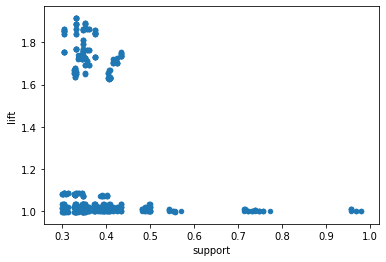

In [8]:
result.plot.scatter(x='support', y='lift')
plt.show()

## 分析“support”与“lift”之间的分布关系：发现 lift 较高的规则分布在 support 较低的位置

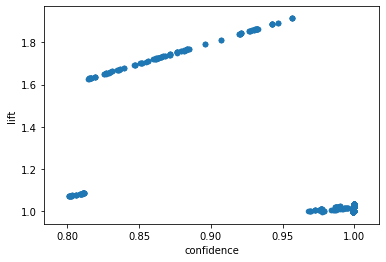

In [9]:
result.plot.scatter(x='confidence', y='lift')
plt.show()

## 分析“confidence”与“lift”之间的分布关系：发现总体趋势是随着confidence的增大，lift也在增大

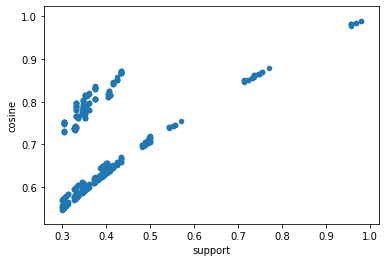

In [10]:
result.plot.scatter(x='support', y='cosine')
plt.show()

## 分析“support”与“cosine”之间的分布关系：总体也有正相关的趋势

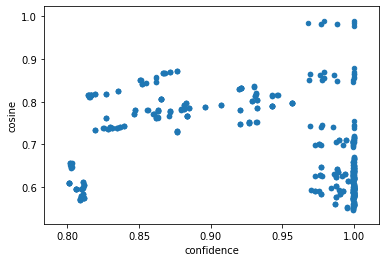

In [11]:
result.plot.scatter(x='confidence', y='cosine')
plt.show()

## 分析“confidence”与“cosine”之间的分布关系：总体趋势较为离散，没有明显的线性关系